# **Decision Support System for Predicting the Popularity of Online News**


## online news popularity prediciton part 1 notebook, aiming at Big data 6 cfu course
**Author**: Ali Akbar Halvaei  
**Course**: Big Data Analytics and text mining  + 3CFU project work

**Professor**: Dr. Stefano Lodi  
**Academic Year**: 2024–2025

---

## 📚 **Sources**

- **Dataset**: [Online News Popularity Data Set - UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/online+news+popularity)  
- **Main Reference Paper**:  
  Ribeiro, M. H., Araújo, M., Gonçalves, P., André Gonçalves, M., & Benevenuto, F. (2017). *A Comparison of Machine Learning Algorithms for Predicting the Popularity of Online News*.  
  [Link to paper](https://repositorium.sdum.uminho.pt/bitstream/1822/39169/1/main.pdf)

---

## 📌 **What We Do Differently**

- We use **PySpark** instead of traditional Python (scikit-learn) to ensure our system is scalable and suitable for Big Data environments.
- We implement the project in a **distributed computing setup** using **Apache Spark** inside a **virtual machine** configured according to course specifications.
- We recreate and validate the paper’s findings using **6 different classification models**.
- We generate ROC curves and evaluate models using multiple performance metrics (AUC, Accuracy, F1-Score, precision, recall).
- The full project runs inside a **parallelized Spark engine**, simulating real-world decision support systems.

---

## 🧪 **Python and Spark Library Versions**

Here are the main libraries used in this notebook:

| Library        | Version |
|----------------|---------|
| Python         | 3.12.x (Ubuntu 24.04) |
| PySpark        | 3.5.1   |
| Pandas         | 2.2.2     |
| Matplotlib     | 3.10.0    |
| scikit-learn   | 1.6.1   |
| Jupyter        | 7.x     |
| seaborn        | 0.13     |


In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import when
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StandardScaler
import pyspark.sql.functions as F
from pyspark.sql.functions import col
import pandas as pd
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

In [2]:
# Start Spark Session
spark = SparkSession.builder \
    .appName("NewsPopularityPrediction") \
    .getOrCreate()

Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/07/28 16:23:09 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [11]:
# Load CSV file with headers and infer data types
data = spark.read.csv("OnlineNewsPopularity.csv", header=True, inferSchema=True)

# Preview schema and first few rows
data.printSchema()

root
 |-- url: string (nullable = true)
 |--  timedelta: integer (nullable = true)
 |--  n_tokens_title: integer (nullable = true)
 |--  n_tokens_content: integer (nullable = true)
 |--  n_unique_tokens: double (nullable = true)
 |--  n_non_stop_words: double (nullable = true)
 |--  n_non_stop_unique_tokens: double (nullable = true)
 |--  num_hrefs: integer (nullable = true)
 |--  num_self_hrefs: integer (nullable = true)
 |--  num_imgs: integer (nullable = true)
 |--  num_videos: integer (nullable = true)
 |--  average_token_length: double (nullable = true)
 |--  num_keywords: integer (nullable = true)
 |--  data_channel_is_lifestyle: integer (nullable = true)
 |--  data_channel_is_entertainment: integer (nullable = true)
 |--  data_channel_is_bus: integer (nullable = true)
 |--  data_channel_is_socmed: integer (nullable = true)
 |--  data_channel_is_tech: integer (nullable = true)
 |--  data_channel_is_world: integer (nullable = true)
 |--  kw_min_min: integer (nullable = true)
 |-- 

According to the mentioned paper, the number of shares for an article to be considered popular is higher than 1400. Thus, we convert the problem into a Binary-Classification task in which all articles with shares less than 1400 are considered unpopular.

In [12]:
# Create 'label' column
data = data.withColumn("label", when(data["shares"] > 1400, 1).otherwise(0))

# View new column
data.select("shares", "label").show(5)


+------+-----+
|shares|label|
+------+-----+
|   593|    0|
|   711|    0|
|  1500|    1|
|  1200|    0|
|   505|    0|
+------+-----+
only showing top 5 rows


# Exploratory Analysis

In [13]:
# Rename all columns to remove leading/trailing spaces
# some columns names are not standard and have spaces at the beginning
for col_name in data.columns:
    new_col = col_name.strip()
    if new_col != col_name:
        data = data.withColumnRenamed(col_name, new_col)

In [9]:
# This cell is only offering descriptive analysis and saves the results into the excel file
# so, just run this cell one time and you don't need to run this everytime you want to run
# other cells
'''

# 1. Identify numeric feature columns
excluded_cols = {"url", "timedelta", "shares"}
feature_cols = [f.name for f in data.schema.fields
                if f.name not in excluded_cols and f.name != "label" and str(f.dataType) != "StringType"]

# Part 1: Global Descriptive Stats (no label)

global_stats = []
for col_name in feature_cols:
    col_stats = data.select(
        F.count(col_name).alias("count"),
        F.mean(col_name).alias("mean"),
        F.expr(f'percentile_approx({col_name}, 0.5)').alias("median"),
        F.stddev(col_name).alias("std"),
        F.min(col_name).alias("min"),
        F.max(col_name).alias("max"),
        (F.max(col_name) - F.min(col_name)).alias("range")
    ).withColumn("feature", F.lit(col_name))
    global_stats.append(col_stats)

# Combine into one DataFrame
global_df = global_stats[0]
for s in global_stats[1:]:
    global_df = global_df.union(s)

# Reorder columns
global_df = global_df.select("feature", "count", "mean", "median", "std", "min", "max", "range")

# Convert to Pandas for export
global_pd = global_df.toPandas()

# Part 2: Grouped Stats by Label (Mean & Std)
summary = []
for col_name in feature_cols:
    stats = data.groupBy("label").agg(
        F.mean(col_name).alias("mean"),
        F.stddev(col_name).alias("std")
    ).withColumn("feature", F.lit(col_name))
    summary.append(stats)

summary_df = summary[0]
for s in summary[1:]:
    summary_df = summary_df.union(s)

summary_df = summary_df.select("feature", "label", "mean", "std")
grouped_pd = summary_df.toPandas()

# Save both to Excel with 2 sheets
with pd.ExcelWriter("exploratory_summary.xlsx") as writer:
    global_pd.to_excel(writer, sheet_name="Global Stats", index=False)
    grouped_pd.to_excel(writer, sheet_name="By Label Stats", index=False)

print("✅ Summary saved to exploratory_summary.xlsx")
'''

'\n\n# 1. Identify numeric feature columns\nexcluded_cols = {"url", "timedelta", "shares"}\nfeature_cols = [f.name for f in data.schema.fields\n                if f.name not in excluded_cols and f.name != "label" and str(f.dataType) != "StringType"]\n\n# Part 1: Global Descriptive Stats (no label)\n\nglobal_stats = []\nfor col_name in feature_cols:\n    col_stats = data.select(\n        F.count(col_name).alias("count"),\n        F.mean(col_name).alias("mean"),\n        F.expr(f\'percentile_approx({col_name}, 0.5)\').alias("median"),\n        F.stddev(col_name).alias("std"),\n        F.min(col_name).alias("min"),\n        F.max(col_name).alias("max"),\n        (F.max(col_name) - F.min(col_name)).alias("range")\n    ).withColumn("feature", F.lit(col_name))\n    global_stats.append(col_stats)\n\n# Combine into one DataFrame\nglobal_df = global_stats[0]\nfor s in global_stats[1:]:\n    global_df = global_df.union(s)\n\n# Reorder columns\nglobal_df = global_df.select("feature", "count", "me

In [14]:
data.groupBy("label").agg(F.mean("shares").alias("avg_shares")).show()

# Drop non-feature columns
data = data.drop("url", "shares")
print("Total records:", data.count())
data.groupBy("label").count().show()  # Check class distribution

+-----+-----------------+
|label|       avg_shares|
+-----+-----------------+
|    1|5907.432573356507|
|    0|948.3744646947515|
+-----+-----------------+

Total records: 39644
+-----+-----+
|label|count|
+-----+-----+
|    1|19562|
|    0|20082|
+-----+-----+



In [15]:
# Select all feature columns
feature_cols = [col for col in data.columns if col != 'label']



# Assemble all features into a single vector column
assembler = VectorAssembler(inputCols=feature_cols, outputCol="rawFeatures")
assembled_data = assembler.transform(data)



# Standardize features (zero mean, unit variance)
scaler = StandardScaler(inputCol="rawFeatures", outputCol="features", withMean=True, withStd=True)
scaler_model = scaler.fit(assembled_data)
scaled_data = scaler_model.transform(assembled_data)

# Show final dataset with label and scaled features
scaled_data.select("label", "features")


DataFrame[label: int, features: vector]

In [9]:
# Use the final scaled_data with 'label' and 'features' columns
train_data, test_data = scaled_data.randomSplit([0.7, 0.3], seed=42)

print(f"Training set size: {train_data.count()}")
print(f"Test set size: {test_data.count()}")


Training set size: 27952
Test set size: 11692


# Training Models

This notebook refers to the 3 algorithm that are chosen for the course itself

1.   Gaussian Naive Bayes
2.   Logistic Regression
3.   Decision Tree Classifier




In [10]:
# Naive Bayes Classifier
from pyspark.ml.classification import NaiveBayes

nb = NaiveBayes(modelType="gaussian", featuresCol="features", labelCol="label")
nb_model = nb.fit(train_data)
nb_predictions = nb_model.transform(test_data)

# Logistic Regression
from pyspark.ml.classification import LogisticRegression

lr = LogisticRegression(featuresCol="features", labelCol="label")
lr_model = lr.fit(train_data)
lr_predictions = lr_model.transform(test_data)


# Decision Tree Classifier
from pyspark.ml.classification import DecisionTreeClassifier

dt = DecisionTreeClassifier(featuresCol="features", labelCol="label")
dt_model = dt.fit(train_data)
dt_predictions = dt_model.transform(test_data)

25/07/26 16:48:31 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
                                                                                

In [11]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator

# Define evaluators
auc_eval = BinaryClassificationEvaluator(labelCol="label", metricName="areaUnderROC")
acc_eval = MulticlassClassificationEvaluator(labelCol="label", metricName="accuracy")
f1_eval = MulticlassClassificationEvaluator(labelCol="label", metricName="f1")
precision_eval = MulticlassClassificationEvaluator(labelCol="label", metricName="precisionByLabel")
recall_eval = MulticlassClassificationEvaluator(labelCol="label", metricName="recallByLabel")

# Logistic Regression Metrics
print("=== Logistic Regression ===")
print("AUC:", auc_eval.evaluate(lr_predictions))
print("Accuracy:", acc_eval.evaluate(lr_predictions))
print("F1 Score:", f1_eval.evaluate(lr_predictions))
print("Precision:", precision_eval.evaluate(lr_predictions))
print("Recall:", recall_eval.evaluate(lr_predictions))

# Decision Tree Metrics
print("\n=== Decision Tree ===")
print("AUC:", auc_eval.evaluate(dt_predictions))
print("Accuracy:", acc_eval.evaluate(dt_predictions))
print("F1 Score:", f1_eval.evaluate(dt_predictions))
print("Precision:", precision_eval.evaluate(dt_predictions))
print("Recall:", recall_eval.evaluate(dt_predictions))

# Gaussian Naive Bayes
print("\n=== Gaussian Naive Bayes ===")
print("AUC:", auc_eval.evaluate(nb_predictions))
print("Accuracy:", acc_eval.evaluate(nb_predictions))
print("F1 Score:", f1_eval.evaluate(nb_predictions))
print("Precision:", precision_eval.evaluate(nb_predictions))
print("Recall:", recall_eval.evaluate(nb_predictions))


=== Logistic Regression ===


AUC: 0.7061393994276349


Accuracy: 0.6530106055422511


F1 Score: 0.6528827419833778


Precision: 0.6520236920039487


Recall: 0.6711261642675699

=== Decision Tree ===


AUC: 0.5742715101894857


Accuracy: 0.6366746493328772
F1 Score: 0.6359502012153354
Precision: 0.6557038150723549
Recall: 0.5908552074513125

=== Gaussian Naive Bayes ===


AUC: 0.4657633455932865
Accuracy: 0.6009237085186452


F1 Score: 0.587168505036084
Precision: 0.5776413084346409
Recall: 0.7805249788314987


In [12]:
#trying different parameters for Decition tree

evaluator = BinaryClassificationEvaluator(labelCol="label", metricName="areaUnderROC")

from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import BinaryClassificationEvaluator

dt_param_grid = ParamGridBuilder() \
    .addGrid(dt.maxDepth, [3, 5, 10]) \
    .addGrid(dt.minInfoGain, [0.0, 0.01]) \
    .addGrid(dt.impurity, ["gini", "entropy"]) \
    .build()


# CrossValidator
dt_cv = CrossValidator(estimator=dt,
                       estimatorParamMaps=dt_param_grid,
                       evaluator=evaluator,
                       numFolds=3)

# Fit
dt_cv_model = dt_cv.fit(train_data)

# Predict
dt_cv_predictions = dt_cv_model.transform(test_data)


In [13]:
auc_eval = BinaryClassificationEvaluator(labelCol="label", metricName="areaUnderROC")
acc_eval = MulticlassClassificationEvaluator(labelCol="label", metricName="accuracy")
f1_eval = MulticlassClassificationEvaluator(labelCol="label", metricName="f1")
prec_eval = MulticlassClassificationEvaluator(labelCol="label", metricName="precisionByLabel")
rec_eval = MulticlassClassificationEvaluator(labelCol="label", metricName="recallByLabel")

print("=== Tuned Decision Tree ===")
print("AUC:", auc_eval.evaluate(dt_cv_predictions))
print("Accuracy:", acc_eval.evaluate(dt_cv_predictions))
print("F1 Score:", f1_eval.evaluate(dt_cv_predictions))
print("Precision:", prec_eval.evaluate(dt_cv_predictions))
print("Recall:", rec_eval.evaluate(dt_cv_predictions))

=== Tuned Decision Tree ===
AUC: 0.5945403922219311


Accuracy: 0.6223913787204927


F1 Score: 0.6221716878833881


Precision: 0.6214541897619824
Recall: 0.6455546147332769


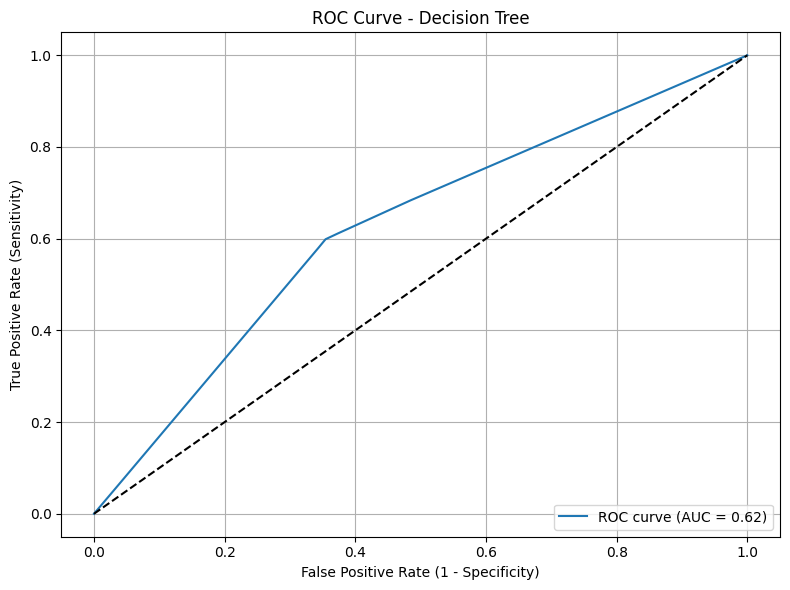

In [14]:
# Example: Use rf_cv_predictions or any other model predictions
from pyspark.sql.functions import col

# Convert Spark DataFrame to Pandas
preds_df = dt_cv_predictions.select("label", "probability").toPandas()
# Extract probability of class 1 (popular)
preds_df["prob_popular"] = preds_df["probability"].apply(lambda v: float(v[1]))



# True labels and predicted probabilities
y_true = preds_df["label"]
y_scores = preds_df["prob_popular"]

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_true, y_scores)
roc_auc = auc(fpr, tpr)

# Plot
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], "k--")  # Random guess line
plt.xlabel("False Positive Rate (1 - Specificity)")
plt.ylabel("True Positive Rate (Sensitivity)")
plt.title("ROC Curve - Decision Tree")
plt.legend(loc="lower right")
plt.grid()
plt.tight_layout()
plt.show()



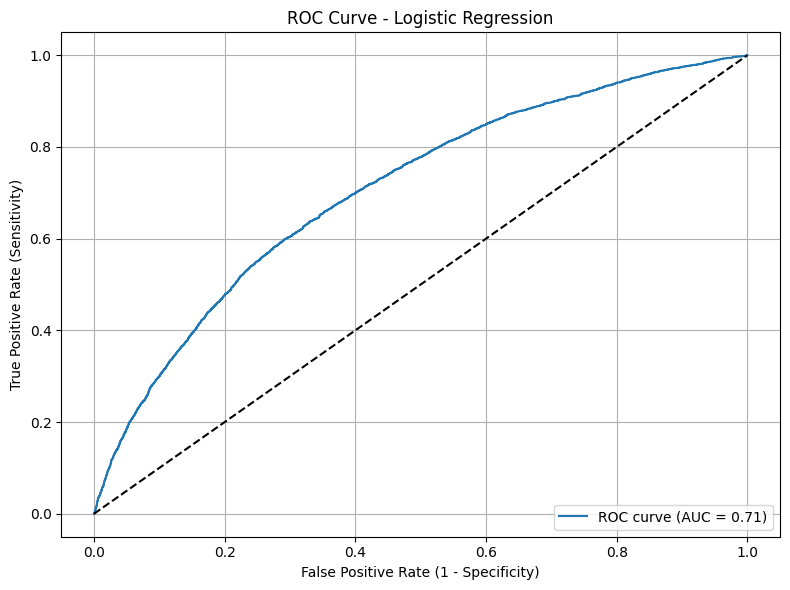

In [15]:
#plot ROC Curve for Logistic Regression

preds_df = lr_predictions.select("label", "probability").toPandas()
preds_df["prob_popular"] = preds_df["probability"].apply(lambda v: float(v[1]))


y_true = preds_df["label"]
y_scores = preds_df["prob_popular"]


fpr, tpr, thresholds = roc_curve(y_true, y_scores)
roc_auc = auc(fpr, tpr)


plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], "k--")  # Random guess line
plt.xlabel("False Positive Rate (1 - Specificity)")
plt.ylabel("True Positive Rate (Sensitivity)")
plt.title("ROC Curve - Logistic Regression")
plt.legend(loc="lower right")
plt.grid()
plt.tight_layout()
plt.show()



## 📈 ROC Curve Overview

The Receiver Operating Characteristic (ROC) curve is used to evaluate the performance of a binary classifier by plotting:

- **True Positive Rate (Sensitivity)** on the Y-axis  
- **False Positive Rate (1 - Specificity)** on the X-axis  

Each point on the ROC curve corresponds to a different classification threshold.

### 🧮 AUC (Area Under the Curve)

- **AUC = 1.0**: Perfect classifier  
- **AUC = 0.5**: Random guessing  
- **AUC > 0.7**: Considered good in real-world settings

In our models, Decision tree showed poor performance according to its ROC curve while Logistic regression showed a better performance. close to what has authors achieved in the referenced article; However, we still can make a little improvement by trying other classification algorithms naming: Gradient Boosted Tree, Random Forest classifier, and Linear SVC in another notebook.

In [16]:
# Extract feature importances from best DT model
importances = dt_cv_model.bestModel.featureImportances

# Convert to Python list
importances_list = importances.toArray().tolist()


In [17]:
# Pair each importance value with its feature name
feature_importance = list(zip(feature_cols, importances_list))

# Sort by importance descending
sorted_importance = sorted(feature_importance, key=lambda x: x[1], reverse=True)

# Print top 10
for feature, score in sorted_importance[:10]:
    print(f"{feature:<40} Importance: {score:.4f}")


kw_avg_avg                               Importance: 0.5478
data_channel_is_entertainment            Importance: 0.2136
is_weekend                               Importance: 0.1974
LDA_02                                   Importance: 0.0413
timedelta                                Importance: 0.0000
n_tokens_title                           Importance: 0.0000
n_tokens_content                         Importance: 0.0000
n_unique_tokens                          Importance: 0.0000
n_non_stop_words                         Importance: 0.0000
n_non_stop_unique_tokens                 Importance: 0.0000


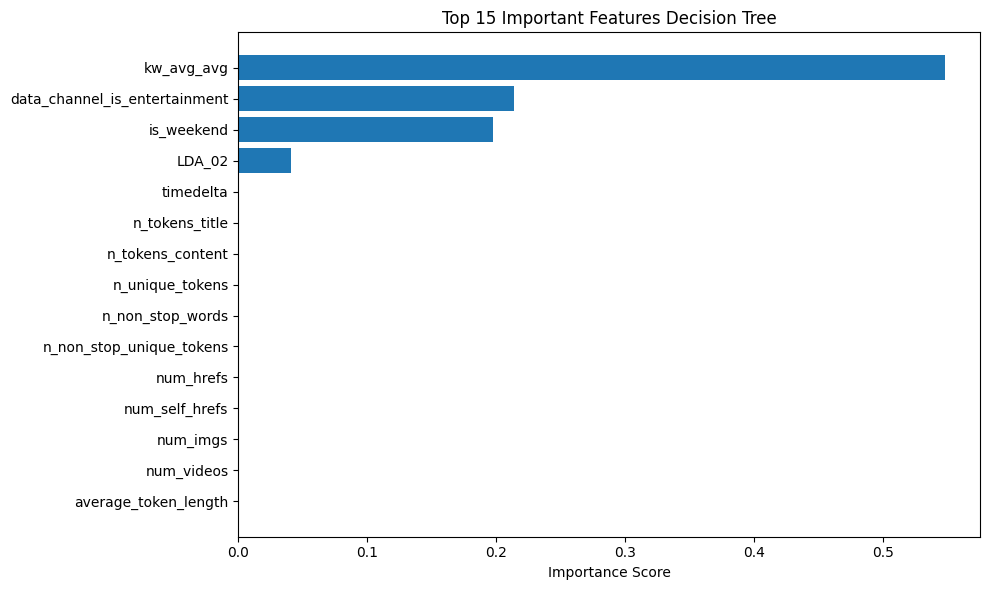

In [18]:

# Unzip top 15 features
top_features, scores = zip(*sorted_importance[:15])

plt.figure(figsize=(10,6))
plt.barh(top_features[::-1], scores[::-1])
plt.xlabel("Importance Score")
plt.title("Top 15 Important Features Decision Tree")
plt.tight_layout()
plt.show()


In [19]:
models_final = {
    "Logistic Regression": lr_predictions,
    "Decision Tree": dt_predictions,
    "Gaussian Naive Bayes": nb_predictions
}

results = []

for name, preds in models_final.items():
    auc = auc_eval.evaluate(preds)
    acc = acc_eval.evaluate(preds)
    f1 = f1_eval.evaluate(preds)
    results.append((name, round(auc, 4), round(acc, 4), round(f1, 4)))

# Print nicely
print(f"{'Model':<25} {'AUC':<10} {'Accuracy':<10} {'F1 Score'}")
for row in results:
    print(f"{row[0]:<25} {row[1]:<10} {row[2]:<10} {row[3]}")


Model                     AUC        Accuracy   F1 Score
Logistic Regression       0.7061     0.653      0.6529
Decision Tree             0.5743     0.6367     0.636
Gaussian Naive Bayes      0.4658     0.6009     0.5872


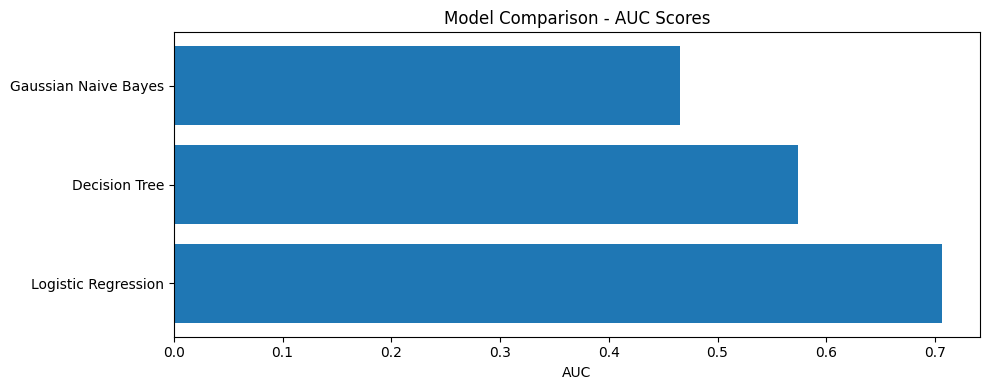

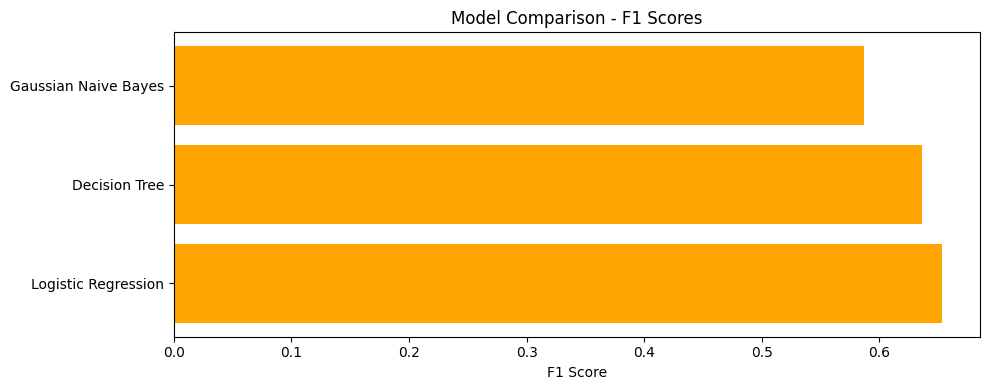

In [20]:


# Split result columns
model_names = [r[0] for r in results]
auc_scores = [r[1] for r in results]
f1_scores = [r[3] for r in results]

# AUC Plot
plt.figure(figsize=(10,4))
plt.barh(model_names, auc_scores)
plt.title("Model Comparison - AUC Scores")
plt.xlabel("AUC")
plt.tight_layout()
plt.show()

# F1 Plot
plt.figure(figsize=(10,4))
plt.barh(model_names, f1_scores, color='orange')
plt.title("Model Comparison - F1 Scores")
plt.xlabel("F1 Score")
plt.tight_layout()
plt.show()


## 📘 Conclusion

In this project, we tackled the challenge of predicting the popularity of online news articles before publication, using only content-based features. The problem was framed as a binary classification task based on a threshold of 1400 shares.

We implemented and evaluated six classification algorithms using PySpark in a distributed environment:

- Logistic Regression  
- Decision Tree  
- Gaussian Naive Bayes

## 📊 Model Comparison: Logistic Regression vs Decision Tree vs Naive Bayes

We compare the performance of three classifiers trained using PySpark: **Logistic Regression**, **Decision Tree**, and **Gaussian Naive Bayes**. The key evaluation metrics are Area Under ROC (AUC), Accuracy, F1 Score, Precision, and Recall.

| Metric        | Logistic Regression | Decision Tree     | Gaussian Naive Bayes |
|---------------|---------------------|--------------------|------------------------|
| AUC           | **0.7061**          | 0.5743             | 0.4658                 |
| Accuracy      | **0.6530**          | 0.6333             | 0.6009                 |
| F1 Score      | **0.6529**          | 0.6329             | 0.5872                 |
| Precision     | 0.6520              | **0.6487**         | 0.5776                 |
| Recall        | **0.6711**          | 0.5978             | **0.7805**             |

### ✅ Summary:

- **Logistic Regression** performs best overall, achieving the highest AUC, accuracy, F1 score, and recall among the three models. It also has a smooth ROC curve with consistent gain across thresholds.

- **Decision Tree**, although simple and interpretable, underperforms significantly in terms of AUC (only 0.55), suggesting weak separation between classes. Its ROC curve is less steep and closer to random chance (diagonal).

- **Gaussian Naive Bayes** exhibits poor AUC and F1 but surprisingly high **recall**, meaning it identifies most positive samples, albeit with lower precision. This behavior is often typical of Naive Bayes classifiers.

### 🔍 ROC Curve Interpretation:

- The ROC curve for **Logistic Regression** is consistently above the diagonal line (random classifier) and results in a decent **AUC of 0.71**, indicating good discriminatory power.

- The **Decision Tree** ROC curve is closer to the diagonal line and jagged, reflecting poor probability calibration and weaker classification confidence.

- **Gaussian Naive Bayes**, although evaluated, shows weak predictive ability with an AUC below 0.5, likely due to assumption violations on input features.

### ✅ Conclusion:

Logistic Regression demonstrates the **most balanced and reliable performance**, making it a strong baseline classifier for this dataset. Decision Tree may still be valuable for interpretability and visualization but is not optimal in isolation. Naive Bayes is computationally lightweight and cannot be useful in this project.
